In [6]:
!pip install numpy pandas seaborn

  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/38/f8/d8fddee9ed0d0c0f4a2132c1dfcf0e3e53265055da8df952a53e7eaf178c/pandas-2.2.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.2 MB/s eta 0:00:00 MB/s eta 0:00:01:01
  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
  Obtaining dependency information for pytz>=2020.1 from https://files.pythonhosted.org/packages/11/c3/005fcca25ce078d2cc29fd559379817424e94885510568bc1bc53d7d5846/pytz-2024.2-py2.py3-none-any.whl.metadata
  Obtaining dependency information for tzdata>=2022.7 from https://files.pythonhosted.org/packages/a6/ab/7e5f53c3b9d14972843a647d8d7a853969a58aecc7559cb3267302c94774/tzdata-2024.2-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [7]:
# Imports
# from pgmpy.factors.discrete import TabularCPD
# from pgmpy.models import BayesianNetwork
from experiment import concert_prob_per_day
import numpy as np
import pandas as pd
import json
import random
import seaborn as sns
import math

## Everything Data

In [9]:
# Load of pairs of friends
friendships = pd.read_csv("grupee_data/friends.csv", skiprows=1, names= ["id1", "id2"])

# Drop any entries with NaN
friendships.dropna(inplace=True)
print(friendships.isna().any()) # Check if it worked

id1    False
id2    False
dtype: bool


In [10]:
attendence_prob = {
    #(id1 likes, id2 likes)
    (True, True): 0.393,
    (True, False): 0.018,
    (False, True): 0.018,
    (False, False): 0.002
}

In [12]:
# Get preferences
with open('grupee_data/preferences.json') as f:
    preferences = json.load(f)

# Create a dict with {id1: {Genre1: 0, Genre2: 1, ...},
#                    id2: {Genre2: 0, Genre2: 1, ...},
#                     ...
#                       }
preferences_dict = {}
for id in preferences:
    temp_dict = {}
    for i, genre in enumerate(concert_prob_per_day.keys()):
        temp_dict[genre] = int(preferences[id][i])

    preferences_dict[int(id)] = temp_dict

## Naive approach
Assume whether a concert is happening and whether two people like the genre are statistically independent

We can then compute if person id1 attends a concert today by:

$$ \sum_{g \in G} \sum_{id2 \in F} P(g) \cdot P(\text{Attend concert})$$

Where: <br>
G = All genres <br>
F = All friends of person id1

And $$P(\text{Attend concert})$$ is defined by:

|id1 likes genre| id2 like genre | P(Attend concert)|
| --- | --- | --- |
| True | True | 0.393 |
| True | False | 0.018 |
| False | True | 0.018 |
| True | True | 0.002 |

In [13]:
# for each possible genre sum up the posibility that that person will attend this genre (today)

def get_total_probability(person_id):

    """
    Parameters
    -----------
    Person: int
        The id of the person whose probability we want to determine

    Returns
    ----------
        total_proability: float
            total probability computed as explained in the markdown above
    """
    total_probability = 0
    # Get list of friends for the person we are considering
    friends = np.concatenate([friendships[friendships["id1"] == person_id]["id2"].values, friendships[friendships["id2"] == person_id]["id1"].values])
    for genre in concert_prob_per_day.keys(): # for every genre get the probability of two friends attending the concert
        for friend in friends:
            p1_likes = preferences_dict[person_id].get(genre)
            p2_likes =  preferences_dict[friend].get(genre)
            
            prob = attendence_prob[(p1_likes, p2_likes)]
            total_probability += prob*concert_prob_per_day[genre]

    return total_probability


In [14]:
# Create a pandas DataFrame with columns = [person_id, total_probability, number of friends]
all_people = preferences_dict.keys()
all_probs = [get_total_probability(person) for person in all_people]

no_of_friends = [len(np.concatenate([friendships[friendships["id1"] == i]["id2"].values, friendships[friendships["id2"] == i]["id1"].values])) for i in all_people]

results = pd.DataFrame({"UserID": all_people, "Total_prob": all_probs, 'No_of_Friends': no_of_friends})

In [15]:
# Sort the results by the total probability
results.sort_values('Total_prob', ascending=False)

,UserID,Total_prob,No_of_Friends
1612,1612,7.407093,113
419,419,6.093090,90
1210,1210,4.921236,92
312,312,4.830340,84
506,506,4.396460,63
...,...,...,...
4623,4623,0.005068,1
4620,4620,0.005068,1
2413,2413,0.005068,1
6765,6765,0.005068,1


<Axes: >

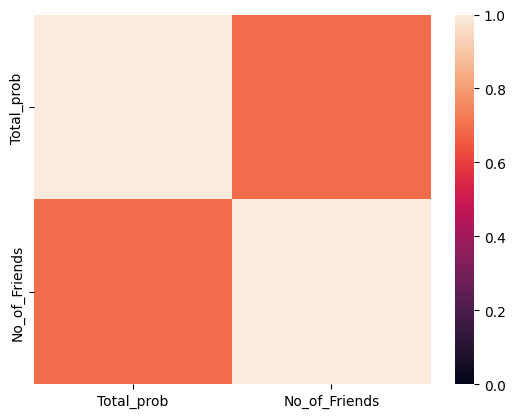

In [16]:
# Check whether or not the number of friends and the total probability is correlated
corr = results[['Total_prob', 'No_of_Friends']].corr()
sns.heatmap(corr, vmin=0)

Obversation from correlation: There is a slight correlation between the number of friends and their probability to attend a concert

In [17]:
# Take the first 12% of entries
no_vaccinated = math.floor(0.12*len(results))

vaccinated  = results.sort_values('Total_prob', ascending=False).iloc[:no_vaccinated]
vaccinated = vaccinated['UserID'].values

In [18]:
vaccinated

array([1612,  419, 1210,  312,  506,  294, 1197,  108, 3764, 1315,  715,
       2435, 1687,  587,  160, 1974,  327, 4011, 2595,  694, 3664, 2654,
       7233,  855, 4207, 1805,  446, 2242, 1923, 7296, 6678,  492, 1947,
        725,  600, 1658,  260, 4024, 1837,  269, 6005,  366, 3578,  904,
       5569, 4352, 2237, 3322,  532, 8201,  416,  554, 4726,  588, 2020,
         48, 4017,  615, 3660,  552, 2894,  444,  168, 2408,  590,  300,
        279,  177, 1305, 4022, 4013, 7273,   17,  942, 7060,    2, 1886,
        114, 1806, 2117, 4935,  480,  384,  349, 1059, 5139,  430, 3498,
       1484,  768,  342,  328,  391, 1526, 1709,  544, 2788,  468, 1504,
       2004, 3417,  985, 4006,  102, 5486, 5797, 7392, 6568, 7359, 3738,
       3495, 8095,  306,  443, 2003,  249,  101,  243, 5254,  320,  555,
       5560,  182,  388, 4977,  284, 4702, 2010, 4060, 5775, 2244, 4530,
       4113,  621,  811,  118,  104, 1877, 2898, 7871,  365,  909, 2604,
        252, 1304, 7278, 1408, 4786, 1316, 4761, 30